In [22]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np
from datetime import datetime
import seaborn as sns

# For handling spatial data formats
from osgeo import ogr

In [23]:
# Load the CSV data into a Pandas DataFrame
df = pd.read_csv('US_Lightning_Forest_Fires.csv')

# Convert LATITUDE and LONGITUDE columns into geometry (points)
geometry = [Point(xy) for xy in zip(df['LONGITUDE'], df['LATITUDE'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Set coordinate reference system (CRS) to WGS84 (common for GPS coordinates)
gdf.set_crs('EPSG:4326', inplace=True)

# Preview the data
gdf.head()


,Unnamed: 0,index,FIRE_YEAR,Fire_Date,DISCOVERY_TIME,STAT_CAUSE_DESCR,Days_to_extinguish_fire,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,FIPS_CODE,FIPS_NAME,geometry
0,0,1,2004,05-12-2004,845.0,Lightning,0.0,1530.0,0.25,A,38.933056,-120.404444,CA,61.0,Placer,POINT (-120.40444 38.93306)
1,1,3,2004,06-28-2004,1600.0,Lightning,5.0,1400.0,0.10,A,38.559167,-119.913333,CA,3.0,Alpine,POINT (-119.91333 38.55917)
2,2,4,2004,06-28-2004,1600.0,Lightning,5.0,1200.0,0.10,A,38.559167,-119.933056,CA,3.0,Alpine,POINT (-119.93306 38.55917)
3,3,5,2004,06-30-2004,1800.0,Lightning,1.0,1600.0,0.10,A,38.635278,-120.103611,CA,5.0,Amador,POINT (-120.10361 38.63528)
4,4,6,2004,07-01-2004,1800.0,Lightning,1.0,1400.0,0.10,A,38.688333,-120.153333,CA,17.0,El Dorado,POINT (-120.15333 38.68833)


In [24]:

# 1. Remove rows where Days_to_extinguish_fire is negative
df = df[df['Days_to_extinguish_fire'] >= 0]

# 2. Handle missing values in Days_to_extinguish_fire by filling with the median
df['Days_to_extinguish_fire'] = df['Days_to_extinguish_fire'].fillna(df['Days_to_extinguish_fire'].median())

# 3. Handle missing values in LATITUDE and LONGITUDE (fill with median)
df['LATITUDE'] = df['LATITUDE'].fillna(df['LATITUDE'].median())
df['LONGITUDE'] = df['LONGITUDE'].fillna(df['LONGITUDE'].median())

# 4. Remove duplicates (if any)
df = df.drop_duplicates()

# 5. Ensure FIRE_DATE and FIRE_YEAR are in correct types (datetime for FIRE_DATE)
df['Fire_Date'] = pd.to_datetime(df['Fire_Date'], errors='coerce')
df['FIRE_YEAR'] = pd.to_numeric(df['FIRE_YEAR'], errors='coerce')

# Check for any remaining missing values
missing_values = df.isnull().sum()
print(f"Missing values after cleaning:\n{missing_values}")

# Optionally: Drop rows where any essential columns have NaN values
# df = df.dropna(subset=['FIRE_YEAR', 'LATITUDE', 'LONGITUDE', 'Days_to_extinguish_fire'])

# Save the cleaned data to a new file for further use
df.to_csv('cleaned_wildfire_data.csv', index=False)

# Proceed with visualizations


Missing values after cleaning:
Unnamed: 0                      0
index                           0
FIRE_YEAR                       0
Fire_Date                       0
DISCOVERY_TIME               6624
STAT_CAUSE_DESCR                0
Days_to_extinguish_fire         0
CONT_TIME                    7807
FIRE_SIZE                       0
FIRE_SIZE_CLASS                 0
LATITUDE                        0
LONGITUDE                       0
STATE                           0
FIPS_CODE                  105600
FIPS_NAME                  105600
dtype: int64


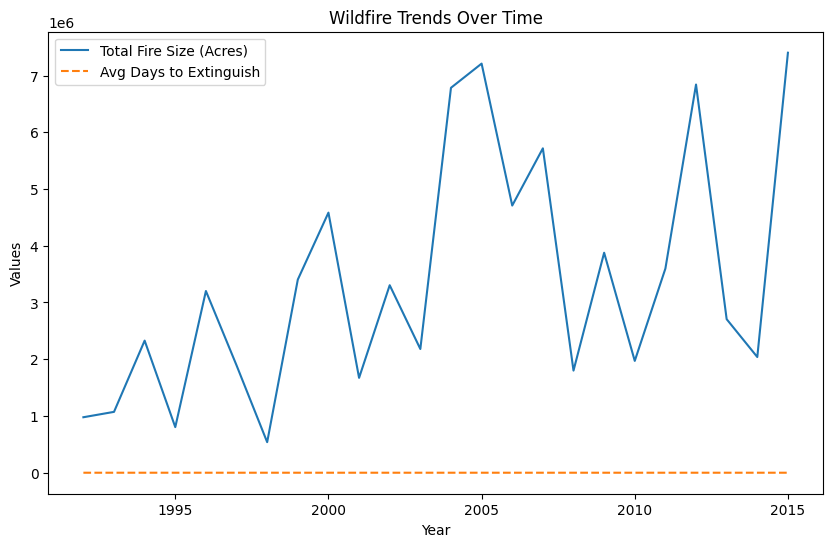

In [25]:
# Group by year
yearly_data = df.groupby('FIRE_YEAR').agg({'FIRE_SIZE': 'sum', 'Days_to_extinguish_fire': 'mean'}).reset_index()

# Plot trends
plt.figure(figsize=(10, 6))
plt.plot(yearly_data['FIRE_YEAR'], yearly_data['FIRE_SIZE'], label='Total Fire Size (Acres)')
plt.plot(yearly_data['FIRE_YEAR'], yearly_data['Days_to_extinguish_fire'], label='Avg Days to Extinguish', linestyle='--')
plt.title('Wildfire Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Values')
plt.legend()
plt.show()


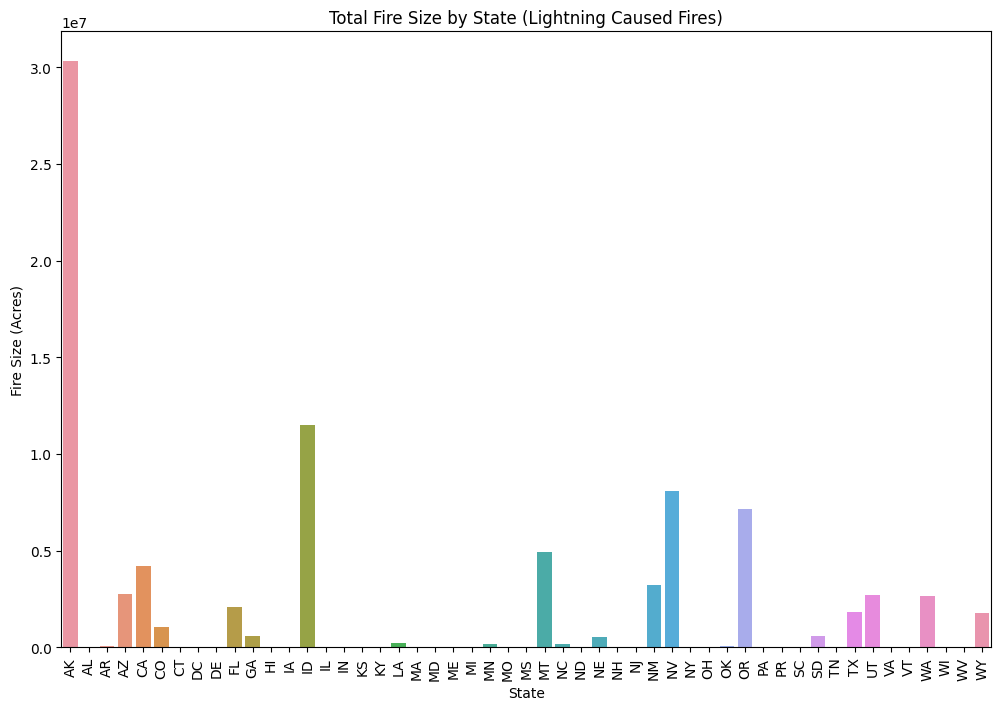

In [26]:
# Filter the GeoDataFrame to include only lightning-caused fires
gdf_lightning = gdf[gdf['STAT_CAUSE_DESCR'] == 'Lightning']

# Aggregate fire size by state
state_fire_size = gdf_lightning.groupby('STATE')['FIRE_SIZE'].sum().reset_index()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.barplot(x='STATE', y='FIRE_SIZE', data=state_fire_size)
plt.xticks(rotation=90)
plt.title('Total Fire Size by State (Lightning Caused Fires)')
plt.xlabel('State')
plt.ylabel('Fire Size (Acres)')
plt.show()


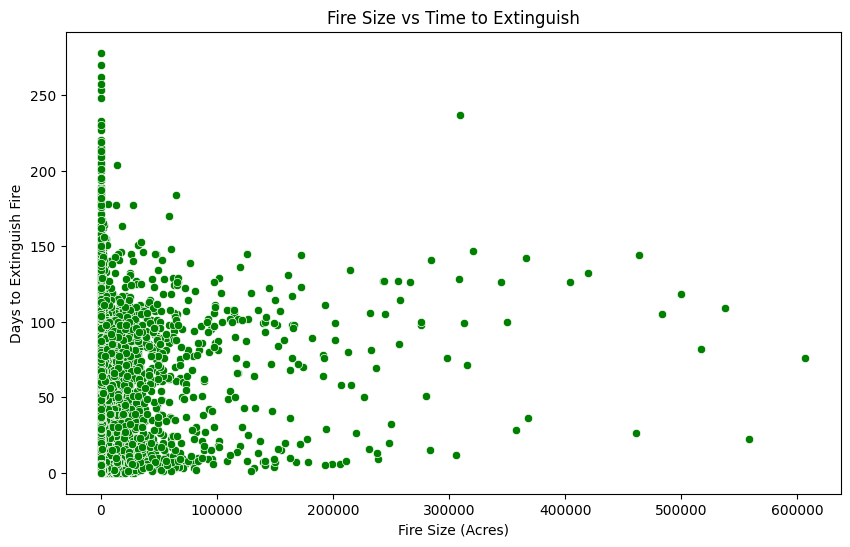

Correlation between Fire Size and Time to Extinguish:                          FIRE_SIZE  Days_to_extinguish_fire
FIRE_SIZE                 1.000000                 0.249094
Days_to_extinguish_fire   0.249094                 1.000000


In [27]:
import seaborn as sns

# Scatter plot to visualize correlation
plt.figure(figsize=(10, 6))
sns.scatterplot(x='FIRE_SIZE', y='Days_to_extinguish_fire', data=df, color='green')
plt.title('Fire Size vs Time to Extinguish')
plt.xlabel('Fire Size (Acres)')
plt.ylabel('Days to Extinguish Fire')
plt.show()

# Correlation coefficient
correlation = df[['FIRE_SIZE', 'Days_to_extinguish_fire']].corr()
print('Correlation between Fire Size and Time to Extinguish:', correlation)


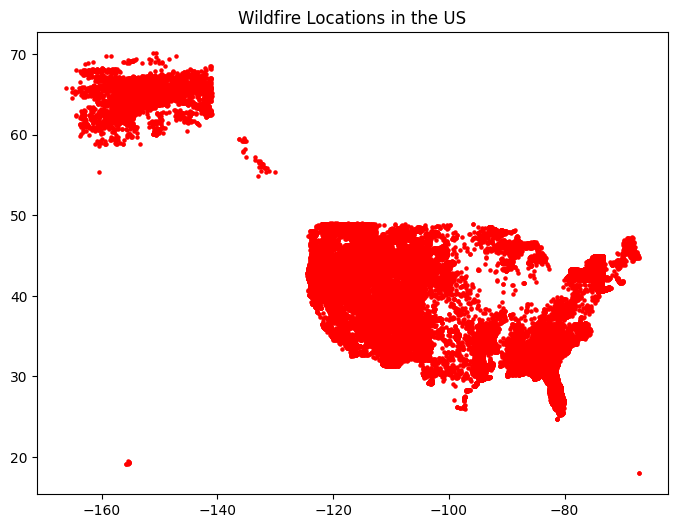

In [28]:
import geopandas as gpd
from shapely.geometry import Point

# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(df['LONGITUDE'], df['LATITUDE'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)
gdf.set_crs('EPSG:4326', inplace=True)

# Plot fire locations
ax = gdf.plot(marker='o', color='red', markersize=5, figsize=(10, 6))
ax.set_title('Wildfire Locations in the US')
plt.show()


In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Load the dataset
df = pd.read_csv('US_Lightning_Forest_Fires.csv')

# Handle NaN in target variable (Days_to_extinguish_fire)
df['Days_to_extinguish_fire'] = df['Days_to_extinguish_fire'].fillna(df['Days_to_extinguish_fire'].median())

# Handle NaN in features (if necessary)
df['LATITUDE'] = df['LATITUDE'].fillna(df['LATITUDE'].median())
df['LONGITUDE'] = df['LONGITUDE'].fillna(df['LONGITUDE'].median())

# Create feature variables (X) and target variable (y)
df['cause_encoded'] = df['STAT_CAUSE_DESCR'].map({'Lightning': 1, 'Human': 0})
X = df[['FIRE_YEAR', 'LATITUDE', 'LONGITUDE', 'cause_encoded']]
y = df['Days_to_extinguish_fire']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Evaluate the model
accuracy = model.score(X_test, y_test)
print(f'Model Accuracy: {accuracy}')



Model Accuracy: 0.2648646521500396


In [30]:
# Save as GeoJSON or Shapefile
gdf_lightning.to_file("processed_wildfire_data.geojson", driver='GeoJSON')
